# Acoustic Positioning System Lab 1: Cross Correlation and TDOAs

### EE16A: Designing Information Devices and Systems I, Fall 2018

**Name 1:** Lizhi Yang

**Login:** ee16a-aby

**Name 2:**

**Login:** ee16a-

#### [Introduction](#w1)
#### [Task 1: Measuring the Similarity of Two Signals](#task1)
#### [Task 2: Extracting information](#task2)
#### [Task 3: Detecting Real Signals](#task3)
#### [Task 4: Separating Signals](#task4)
#### [Task 5: Computing Distances](#task5)
#### [Task 6: Testing with Real Data](#task6)

<a id='w1'></a>
## Introduction

This is a long lab, but it is all software. You will not have to use any sort of hardware, so if you do not finish within the allotted time, feel free to finish at home and get this lab checked off next week. There are many conclusive tests that will guide you. If you get stuck, drop by office hours for a lab TA and ask for help or post on Piazza.

There are various positioning systems in our life, and we use them every day. The most commonly used one is the [Global Positioning System (GPS)](http://en.wikipedia.org/wiki/Global_Positioning_System). The navigation systems in cars, Google Maps, cell phones, and even rockets and spaceships all use the GPS.

In this lab, we are going to explore the basics of these navigation systems and build our own. At the end of this lab module, you will have written software (and tested it on real data) that can give you your location in a 2D space!

## Basic Principle of Operation
GPS satellites broadcast a variety of measurements including time from a very precise clock, as well as the satellite's position, velocity, etc. GPS receivers make use of the fact that light propagates at a known speed, so the receiver can compute distance from the satellite by measuring how long it takes the GPS signal to propagate from the satellite to the receiver.

<center>
<img src="img/wk1_standard_gps.png" align="center" style="height:250px">
**Source**: [Kathleen Cantner, AGI](http://www.earthmagazine.org/article/precise-fault-how-gps-revolutionized-seismic-research)
</center>

Just like the GPS, we will use speakers as our signal emitters (like the "GPS satellite"), and use microphones (our version of the "GPS radio chip") to receive the signals. Using the microphone, we have essentially created an Acoustic Positioning System (APS), as opposed to a Global Positioning System. We can determine distances to each satellite based on the delay between the times at which we receive each signal.

Let's start with the block diagram below illustrating the positioning process flow we'll implement in this lab.

<a id='background'></a>
## Extracting Information
The block diagram below shows a high level overview of the full system. We begin by transmitting the signal from the speakers. This signal is then recorded by the microphone and converted to a format we can use for further processing. Next, the signal from each speaker are identified and the time differences are used to determine locations.

<center>
<img src="img/signals.png" align="center" style="height:450px">
</center>

<a id='task1'></a>
## <font color="blue">Task 1: Measuring the Similarity of Two Signals

Just like real GPS, our APS setup will have multiple speaker-satellites emitting signals, and a single microphone receiver. The signal that we receive at the microphone will be a sum of the individual speaker outputs. We will sift through the microphone signal to find audio signals that are unique from each speaker. We will use a tool called **cross-correlation** to perform this sifting. In order to perform cross-correlation, we are essentially comparing the signal we receive with a stored copies of the signal coming from the speakers. 

**[Cross-correlation](http://en.wikipedia.org/wiki/Cross-correlation)** is a measure of similarity between two signals. It is a mathematical operation defined by taking successive products as one function slides past the other. More intuitively this is a measure of the "common area" or "overlap" between two signals with respect to time. For discrete signals, the "common area" at time $t$ is the product of the two signals evaluated at that time. Both a mathematical definition and an animation are shown below where $x$ and $y$ are real valued functions.

From lecture, we have learned how to calculate the cross-correlation vector for periodic signals. Let $\vec{x}$ and $\vec{y}$ are $N$-periodic signals. $m^{th}$ element of the cross-correlation vector $\vec{\rho_{xy}}$ is like below $(m=0,1,...,N-1)$:  

$$\rho_{xy}[m] \stackrel{\mathrm{def}}{=} \sum_{n=0}^{N-1} x[n] y[mod(n-m,N)]$$

<img src="img/cross_correlation_animation_auto-tune.gif" border="0" alt="Animation demonstrating cross-correlation.">

Let's look at the correlation equation carefully and see what it means. $\rho_{xy}[m]$ is an inner product of two $N$-periodic vectors: $\vec{x}[n]$ and $\vec{y}[mod(n-m,N)]$ where $m$ is an integer ranging from $0$ to $N-1$. $\vec{y}[mod(n-m,N)]$ is a $m$-circular-shifted version of $\vec{y}[n]$. To be specific, $\vec{y}[n-m]$ is $\vec{y}[n]$ delayed by $m$. If $n-m$ is out of the range $[0, N-1]$, we divide $n-m$ with $N$ and take a positive remainder within the $[0, N-1]$ range. Graphically, you can think that correlating $\vec{x}$ and $\vec{y}$ is sliding $\vec{y}$ circularly along $\vec{x}$ and multiplying the entries that align and adding them together. 

Let's understand this operation better with a simple numerical example. 

Let $\vec{x} = \begin{bmatrix} 1 & 2 & 3 & 2 \end{bmatrix}^T$ and $\vec{y} = \begin{bmatrix} -1 & 0 & 1 & 0\end{bmatrix}^T$. Here $\vec{x}$ and $\vec{y}$ have period $N$=4.

Cross-correlation vector $\vec{\rho_{\vec{x} \vec{y}}}$ is:

$$ \vec{\rho}_{\vec{x} \vec{y}} = \begin{bmatrix} \rho_{\vec{x} \vec{y}}[0] \\  \rho_{\vec{x} \vec{y}}[1] \\  \rho_{\vec{x} \vec{y}}[2] \\  \rho_{\vec{x} \vec{y}}[3] \end{bmatrix} = \begin{bmatrix} 2 \\ 0 \\ -2 \\ 0 \end{bmatrix} $$

$$ \rho_{\vec{x} \vec{y}}[0] = \left< \begin{bmatrix} 1 \\ 2 \\ 3 \\ 2 \end{bmatrix}, \begin{bmatrix} -1 \\ 0 \\ 1 \\ 0 \end{bmatrix} \right> = 2, \hspace{15pt}
\rho_{\vec{x} \vec{y}}[1] = \left< \begin{bmatrix} 1 \\ 2 \\ 3 \\ 2 \end{bmatrix}, \begin{bmatrix} 0 \\ -1 \\ 0 \\ 1 \end{bmatrix}\right> = 0 $$

$$\rho_{\vec{x} \vec{y}}[2] = \left< \begin{bmatrix} 1 \\ 2 \\ 3 \\ 2 \end{bmatrix}, \begin{bmatrix} 1 \\ 0 \\ -1 \\ 0 \end{bmatrix}\right> = -2, \hspace{15pt}
\rho_{\vec{x} \vec{y}}[3] = \left< \begin{bmatrix} 1 \\ 2 \\ 3 \\ 2 \end{bmatrix}, \begin{bmatrix} 0 \\ 1 \\ 0 \\ -1 \end{bmatrix}\right> = 0
$$

The correlation vector suggests that $\vec{x}[n]$ is most similar with $\vec{y}[n]$ in positive sense, or most similar with $\vec{y}[n-2]$ in negative sense. $\vec{x}[n]$ is least similar with $\vec{y}[n-1]$ and $\vec{y}[n-3]$ (zero correlation). This makes sense becuase $\vec{y}$ can be constructed by simply giving an offset to $\vec{x}$ ($\vec{y} = \vec{x} - 2$). 

A natural question one could have is: what would happen if we cross-correlate signals for more than one period? Why is taking cross-correlation for a single period enough? Let's test this by repeating the example above with more than one period.

Based on the example above, now we take cross-correlation for two periods. Let $\vec{x} = \begin{bmatrix} 1 & 2 & 3 & 2 & 1 & 2 & 3 & 2 \end{bmatrix}^T$ and $\vec{y} = \begin{bmatrix} -1 & 0 & 1 & 0 & -1 & 0 & 1 & 0\end{bmatrix}^T$. This is a repeat of the $\vec{x}$ and the $\vec{y}$ above.

Cross-correlation vector $\vec{\rho_{\vec{x} \vec{y}}}$ is:

$$\vec{\rho}_{\vec{x} \vec{y}} = \begin{bmatrix} \rho_{\vec{x} \vec{y}}[0] \\ \rho_{\vec{x} \vec{y}}[1] \\ \rho_{\vec{x} \vec{y}}[2] \\ \rho_{\vec{x} \vec{y}}[3] \\ \rho_{\vec{x} \vec{y}}[4] \\ \rho_{\vec{x} \vec{y}}[5] \\ \rho_{\vec{x} \vec{y}}[6] \\ \rho_{\vec{x} \vec{y}}[7] \\ \end{bmatrix} = \begin{bmatrix} 4 \\ 0 \\ -4 \\ 0 \\ 4 \\ 0 \\ -4 \\ 0\end{bmatrix}$$

Unsurprisingly, the new two-period cross-correlation vector does not give us a new information compared to the single-period cross-correlation vector in the previous example. The two-period cross-correlation vector is simply a repeat of the single-period cross-correlation vector with a scale factor of two. 

This happens because we shift $\vec{y}$ circularily based on its period.

**NOTE**: In a real world, we often cross-correlate $\vec{x}$ and $\vec{y}$ multiple times, because either $\vec{x}$ or $\vec{y}$ is not perfectly $N$-periodic due to "noise", meaning that random undesired readings are added to the desired signals. We often compensate by having data spanning multiple periods and correlating them. We will explore this more in later part of this lab and see how it can reduce noise.

## Run the cell below to import the necessary helper functions.

In [11]:
from __future__ import division
%pylab inline
import random
import math
import numpy as np
%run support_code/virtual.py
%run support_code/signals.py
%run support_code/demod.py
from IPython.html.widgets import *

Populating the interactive namespace from numpy and matplotlib


/home/yanglizhi/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'Widget', 'Text', 'interactive', 'sqrt', 'cos', 'test', 'pi', 'sin', 'Button']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


The cell below illustrates another example of cross-correlation, where signal 1 and signal 2 may be referred to as $\vec{x}$ and $\vec{y}$ (from the equation given above), respectively. The output plots graphically show the starting point of cross-correlation, then the shifting of signal 2 with respect to signal 1 and the resulting cross-correlation at each step. The full cross-correlation is displayed at the end.

input signal1: [1 2 3 2 1 0]
input signal2: [3 1 0 0 0 1]
cross-correlation:[5, 10, 13, 10, 5, 2]


Text(0.5, 1.0, 'Cross-correlation (single-period)')

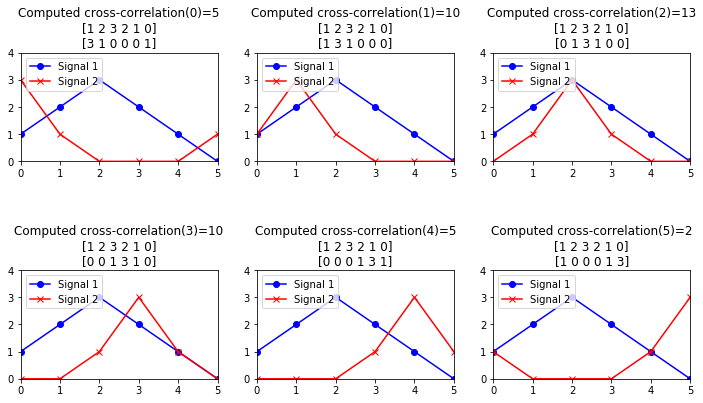

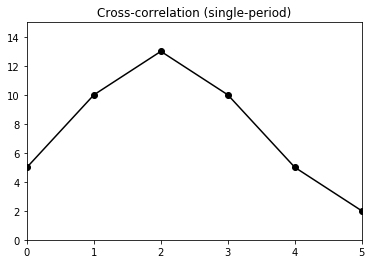

In [12]:
"""Compute the cross_correlation of two given periodic signals    
Args:
signal1 (np.array): input signal 1
signal2 (np.array): input signal 2

Returns:
cross_correlation (np.array): circular cross-correlation of signal1 and signal2

>>> cross_correlation([0, 1, 2, 3], [0, 2, 3, 0])
[8, 13, 6, 3]
"""
# Input signals for which to compute the cross-correlation
signal1 = np.array([1, 2, 3, 2, 1, 0])
signal2 = np.array([3, 1, 0, 0, 0, 1])
print('input signal1: '+str(signal1))
print('input signal2: '+str(signal2))

# Use the numpy.roll function to shift signal2 in a circular way
# Use the numpy.correlate function to convolute signal1 and signal2
# Index [0] is used to convert a 1x1 array into a number
corr = [np.correlate(signal1, np.roll(signal2,k))[0] for k in range(len(signal2))]
print( 'cross-correlation:'+str(corr)) 

# Plot each operation required to compute the cross-correlation
plt.figure(figsize=(12,6))
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.subplots_adjust(hspace = 1);
    plt.plot(signal1, 'bo-', label='Signal 1')
    plt.plot(signal2, 'rx-', label='Signal 2')
    plt.xlim(0, 5)
    plt.ylim(0, 4)  
    plt.legend(loc = 'upper left') 
    plt.title('Computed cross-correlation(%d)=%d\n%s\n%s'%(i, np.dot(signal1, signal2), str(signal1), str(signal2)))
    signal2 = np.roll(signal2, 1)
    
# Adjust subplot spacing
#plt.tight_layout()
plt.figure()
plt.plot(corr,'ko-') 
plt.xlim(0, len(signal2)-1)
plt.ylim(0, 15)
plt.title('Cross-correlation (single-period)')

**<font color="red"> Based on the final result (the cross-correlation plot), how many samples (and in which direction) do you need to shift signal 2 in order to get it to match the best with signal 1? In other words, what does the x-axis on the correlation plot indicate?**

YOUR ANSWER HERE:

**We will repeat the same example as above with a two period case.**

In [ ]:
# Here we repeat the above example for a two-period case

# Input signals for which to compute the cross-correlation
# Make signals periodic with the numpy.tile function
Nrepeat = 2
signal1 = np.array([1, 2, 3, 2, 1, 0])
signal1 = np.tile(signal1, Nrepeat)
signal2 = np.array([3, 1, 0, 0, 0, 1])
signal2 = np.tile(signal2, Nrepeat)
print('input signal1: '+str(signal1))
print('input signal2: '+str(signal2))

# Use the numpy.roll function to shift signal2 in a circular way
# Use the numpy.correlate function to convolute signal1 and signal2
# Index [0] is used to convert a 1x1 array into a number
corr = [np.correlate(signal1, np.roll(signal2,k))[0] for k in range(len(signal2))]
print( 'cross-correlation:'+str(corr)) 

# Plot each operation required to compute the cross-correlation
plt.figure(figsize=(12,12))
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

for i in range(12):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace = 1);
    plt.plot(signal1, 'bo-', label='Signal 1')
    plt.plot(signal2, 'rx-', label='Signal 2')
    plt.xlim(0, 11)
    plt.ylim(0, 4)  
    plt.legend(loc = 'upper left') 
    plt.title('Computed cross-correlation(%d)=%d\n%s\n%s'%(i, np.dot(signal1, signal2), str(signal1), str(signal2)))
    signal2 = np.roll(signal2, 1)
    
# Adjust subplot spacing
#plt.tight_layout()
plt.figure()
plt.plot(corr,'ko-') 
plt.xlim(0, 11)
plt.ylim(0, 28)
plt.title('Cross-correlation (two-period)')

**<font color="red"> What is relationship between the two-period cross-correlation and the single-period cross-correlation?**

YOUR ANSWER HERE:

**<font color="red">Based on example shown above, implement the function below that will compute and return the cross-correlation of two input signals having same length.**

**Things to consider:**
  * Built in `numpy` functions to compute sums of products mentioned above
  * Length of the input signals
  * Built in `numpy` functions shown above to shift a signal
  
*Hint:* Use operations such as `np.dot` and `np.roll` for array sum of products and array shifting, respectively. See the doc tests in the function for what to expect in the output. If your function cares about which signal is longer, you may be approaching this incorrectly.

In [ ]:
def cross_correlation(signal1, signal2):
    """Compute the cross_correlation of two given periodic signals    
    Args:
    signal1 (np.array): input signal 1
    signal2 (np.array): input signal 2
    
    Returns:
    cross_correlation (np.array): cross-correlation of signal1 and signal2
    
    >>> cross_correlation([0, 1, 2, 3], [0, 2, 3, 0])
    [8, 13, 6, 3]
    """
    # BEGIN 
    # YOUR CODE HERE
    
    # END 
    # Do not use np.correlate or np.convolve
    # Build your own correlation code (hint: use np.dot and np.roll)

In [ ]:
def test_correlation_plot(signal1, signal2, lib_result, your_result):
    # Plot the output
    fig = plt.figure(figsize=(8,3))    
    ax = plt.subplot(111)
    str_corr='Correct Answer (length='+str(len(lib_result))+')'
    str_your='Your Answer (length='+str(len(your_result))+')'
    
    ax.plot([x-len(signal2)+1 for x in range(len(lib_result))], lib_result, 'k', label=str_corr, lw=1.5)    
    ax.plot([x-len(signal2)+1 for x in range(len(your_result))], your_result, '--r', label=str_your, lw = 3)
    ax.set_title("Cross correlation of:\n%s\n%s"%(str(signal1), str(signal2)))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# You can change these signals to get more test cases
# Test 1
signal1 = np.array([1, 5, 8, 6])
signal2 = np.array([1, 3, 5, 2])

# Run the test
lib_result, your_result = test_correlation(cross_correlation, signal1, signal2)
test_correlation_plot(signal1, signal2, lib_result, your_result)

# Test 2
signal1 = np.array([1, 5, 8, 6, 1, 5, 8, 6])
signal2 = np.array([1, 3, 5, 2, 1, 3, 5, 2])

# Run the test
lib_result, your_result = test_correlation(cross_correlation, signal1, signal2)
test_correlation_plot(signal1, signal2, lib_result, your_result)

# Test 3
signal1 = np.array([1, 3, 5, 2])
signal2 = np.array([1, 5, 8, 6])

# Run the test
lib_result, your_result = test_correlation(cross_correlation, signal1, signal2)
test_correlation_plot(signal1, signal2, lib_result, your_result)

Before we move on, **let's replace your custom-written cross-correlation function with something more efficient** to save time in running the next parts. Just run the code below to overwrite your initial function. You do not need to understand our implementation of cross correlation. Take EE120 if you are interested!


In [ ]:
def cross_correlation(signal1, signal2):
    """Compute the cross_correlation of two given periodic signals    
    """
    return np.fft.ifft(np.fft.fft(signal1) * np.fft.fft(signal2).conj()).real

<a id='task2'></a>
## <font color="blue">Task 2: Extracting Information
We now have a powerful tool to measure how similar two signals are, and will now explore how to use that in the context of our acoustic positioning system.

Our positioning system will be transmitting what we will call a *beacon signal* from each speaker. Figure 3a shows example waveforms of a system composed of two beacons. The beacons are synchronized, meaning each beacon signal is transmitted from one of the speakers at the same time. Figure 3b demonstrates a scenario where the microphone is farther away from beacon 2, picking up its signal with a 3 millisecond delay with respect to beacon 1.

**Figure 3**
<img src="img/Slide2.tiff.png" width=700px></img>

The raw received signal is the black line shown in Figure 4a, which is a superposition of beacon 1 and the delayed beacon 2 signals. Performing a *cross-correlation* of the recorded audio signal with stored copies of each beacon signal will tell us the time when the beacon signal arrives at the microphone. This will be the time that has maximum cross-correlation for a given beacon. As shown in Figure 4b, the cross-correlation of the recorded audio with a stored copy of beacon 1 has a maximum location that is separated by 3 milliseconds from the maximum location of the cross-correlation with beacon 2. Using this separation, we can infer that the distance of the microphone from the first beacon is less than the distance from the second beacon.

**Figure 4**
<img src="img/Slide3.tiff.png" width=700px></img>

As you can see, even though the first and second beacon signals are different, there is still some non-zero cross-correlation between them, and there is noise that complicates the situation. In order to robustly identify the beacon signals with our single microphone recording, we would like for the same beacon signal to have a large cross-correlation with itself, but a very small cross-correlation with all of the others. 

Real GPS deals with this exact same problem and uses pseudorandom binary sequences (signals composed of just 1s and 0s), also known as **Gold Codes**, constructed with exactly this property: they have small cross-correlation at all shifts, small autocorrelation at non-zero shifts compared to the auto-correlation value at zero. The theory and implementation of these signals is beyond the scope of this class, but simply understanding the properties of cross correlation explained above is enough to show why we will be using them. In the support code for this lab over the next few weeks, we have provided a large set of Gold Codes that are designed to work together well. 

In the next cell, we will demonstrate three Gold Codes and do a small simulation of the audio beacons.

In [ ]:
# Model the sending of stored beacons, first 2000 samples
sent_0 = beacon[0][:2000]
sent_1 = beacon[1][:2000]
sent_2 = beacon[2][:2000]

# Model our received signal as the sum of each beacon, with some delay on each beacon.
delay_samples0 = 0;
delay_samples1 = 0;
delay_samples2 = 0;
received = np.roll(sent_0,delay_samples0) + np.roll(sent_1,delay_samples1) + np.roll(sent_2,delay_samples2)

def pltBeacons(delay_samples0,delay_samples1,delay_samples2):
    received_new = np.roll(sent_0,delay_samples0) + np.roll(sent_1,delay_samples1) + np.roll(sent_2,delay_samples2)
    plt.figure(figsize=(10,4))
    plt.subplot(2, 1, 1)
    plt.plot(received_new), plt.title('Received Signal (sum of beacons)'), plt.xlabel('Samples'), plt.ylabel('Amplitude')
    
    ax = plt.subplot(2, 1, 2)
    corr0 = cross_correlation(received_new, sent_0)
    corr1 = cross_correlation(received_new, sent_1)
    corr2 = cross_correlation(received_new, sent_2)
    plt.plot(range(-1000,1000), np.roll(corr0, 1000))
    plt.plot(range(-1000,1000), np.roll(corr1, 1000))
    plt.plot(range(-1000,1000), np.roll(corr2, 1000))
    legend( ('Corr. with Beacon 0', 'Corr. with Beacon 1', 'Corr. with Beacon 2') )
    plt.title('Cross-correlation of received signal and stored copy of Beacon n')
    plt.xlabel('Samples'), plt.ylabel('Correlation')
    plt.tight_layout()
    plt.draw()
    
interact(pltBeacons, delay_samples0 = (-500,500,10), delay_samples1 = (-500,500,10), delay_samples2 = (-500,500,10))

The sliders control the delay of each beacon (in units of samples). Play with the delay values for each beacon and see how the cross-correlation plot changes. If the slider doesn't appear / work, you can manually change the values in the tuples for `delay_samples0`, `1`, and `2`. For example, try `delay_samples0 = (-300, 700, 10)` and see how the plot changes.

**<font color="red">Pick some non-zero values for the sliders and comment on the location of the peak for each cross correlation. What is the relationship between the correlation peak and the delay for this part?**

YOUR ANSWER HERE:

If you are given some beacon signals and a received signal, can you compute when (in sample) each beacon signal arrives?

**<font color="red">Implement a helper function `identify_peak` which takes in a signal with a single global maximum and returns the index of the peak of the signal.** <font color="red">This should be zero-indexed, as shown in the example input/output of the function below, instead of the way we've been time-indexing before.

In [ ]:
def identify_peak(signal):
    """Returns the index of the peak of the given signal.
    Args:
    signal (np.array): input signal
    
    Returns:
    index (int): index of the peak
    
    >>> identify_peak([1, 2, 5, 7, 12, 4, 1, 0])
    4
    >>> identify_peak([1, 2, 2, 199, 23, 1])
    3
    """
    # BEGIN 
    # YOUR CODE HERE

    # END

**<font color="red"> Implement a function `arrival_time`, which uses cross-correlation to identify the times at which each beacon arrived in samples.**

In [ ]:
def arrival_time(beacons, signal):
    """Returns a list of arrival times (in samples) of each beacon signal.
    Args:
    beacons (list): list in which each element is a numpy array representing one of the beacon signals
    signal (np.array): input signal, for example the values recorded by the microphone
    
    Returns:
    arrival_time [samples] (list): arrival time of the beacons in the order that they appear in the input 
    (e.g. [arrival of beacons[0], arrival of beacons[1]...])
    """    
    arrival_time = []
    # BEGIN
    # YOUR CODE HERE

    #END
    return arrival_time

**<font color="red">Verify the following tests for each of the above functions passes.**

In [ ]:
test(cross_correlation, identify_peak, arrival_time, 2)

**Below code takes couple of seconds**

In [ ]:
# This is much more conclusive test that will take a while to run
test(cross_correlation, identify_peak, arrival_time, 3)

<a id='task3'></a>
## <font color="blue">Task 3: Detecting Real Signals

Now that we have reviewed the theoretical basis of cross-correlation and shown that it can be used to detect simulated signals, we will test the same functions you wrote with real data.

For convenience, we have pre-recorded some sample audio from the real setups you will be using to do APS 2, which you will be using through the rest of this task.

In [ ]:
received_signal = load('sig.npy')

# Plot the received signal
plt.figure(figsize=(18,4))
plt.plot(received_signal)

Now you can test your code! Don't worry if you cannot understand the codes below - you will eventually understand that by the end of the next lab! This may take a full minute to run.


In [ ]:
import scipy.signal
# Convert the received signals into the format our functions expect
%run support_code/demod.py
demod = demodulate_signal(received_signal)
Lperiod = len(beacon[0])
Ncycle = len(demod) // Lperiod
sig = []
# Iterate through beacons
for ib, b in enumerate(beacon[:4]):
    s = cross_correlation(demod[0:Lperiod],b)
    # Iterate through cycles
    for i in range(1,Ncycle):
        s = np.hstack([s, cross_correlation(demod[i*Lperiod:(i+1)*Lperiod], b)])
    if ib==0: sig = s
    else:     sig = np.vstack([sig, s])
sig = [average_signal(s) for s in sig]

In [ ]:
# Plot the cross-correlation with each beacon
plt.figure(figsize=(18,4))
for i in range(len(sig)):
    plt.plot(range(len(sig[i])), sig[i], label="Beacon %d"%(i+1))
plt.legend()

# Scale the x axis to show +/- 1000 samples around the peaks of the cross correlation
peak_times = ([argmax(sig[i]) for i in range(len(sig))])
plt.xlim(max(min(peak_times)-1000, 0), max(peak_times)+1000)

As you can see (if you have the correct implementation), we should have four nice peaks after doing the cross-correlation. 

<a id='task4'></a>
# <span style="color:blue">Task 4: Separating Signals and Beacons</span>

Recall from before: even though we only have a single microphone receiving signals from multiple beacons, we can use cross-correlation to determine the time (in units of samples) at which each signal arrives. We call this process *signal separation*.

<center>
<img src="img/wk2_separated.png" style="height:256px" />
</center>

**<span style="color:red">Read over `separate_signal` function below.</span>**

In [ ]:
def separate_signal(raw_signal):
    """Separate the beacons by computing the cross correlation of the raw signal 
    with the known beacon signals.

    Args:
    raw_signal (np.array): raw signal from the microphone composed of multiple beacon signals
    
    Returns (list): each entry should be the cross-correlation of the signal with one beacon
    """
    Lperiod = len(beacon[0])
    Ncycle = len(raw_signal) // Lperiod
    for ib, b in enumerate(beacon):
        c = cross_correlation(raw_signal[0:Lperiod],b)
        # Iterate through cycles
        for i in range(1,Ncycle):
            c = np.hstack([c, cross_correlation(raw_signal[i*Lperiod:(i+1)*Lperiod], b)])
        if (ib==0): cs = c
        else:       cs = np.vstack([cs, c])
    return cs

Before we move on to converting time differences into positions, we first need to consider several potential issues with our positioning system. 

1. Our beacons play on a loop at a fixed rate, however we don't know when in the loop we started recording. For example, if we record for exactly the number of samples of a beacon, we may have started recording after some of the beacon signals reached the microphone.
<br/><br/>
3. You may notice that the height of the peaks in your final output is dependent on the volume of the speakers. Additionally, like all of the other systems, the output will be affected by noise.


The beacon signals repeat every **230 ms**, and we record for approximately **2.5 s**. Because of this we are recording the **same** beacon signals multiple times, and assuming our microphone isn't moving we only need **one set of measurements** to determine the time differences between them. 

**<span style="color:red">How can we use our full recorded signal to solve some of the problems above and make our system more robust? Hint: We only need one recording of the beacon signals, but we wind up with many repeats. How can we use this 'extra' information to our advantage?</span>**

YOUR ANSWER HERE

**<span style="color:red">We have implemented a function that makes this improvement below. Review the average_sigs() function and be prepared to explain what it does.</span>**

In [ ]:
def average_sigs(cross_correlations):
    Lperiod = len(beacon[0])
    Ncycle = len(cross_correlations[0]) // Lperiod
    avg_sigs = []
    for c in cross_correlations:
        reshaped = c.reshape((Ncycle,Lperiod))
        averaged = np.mean(np.abs(reshaped),0)
        avg_sigs.append(averaged)

    return avg_sigs

def signal_generator(x, y, noise=0):
    raw_signal = add_random_noise(simulate_by_location(x, y), noise)
    return demodulate_signal(raw_signal)

**<span style="color:red">Run the code below to plot how the quality of the signal improves after running this function.</span>**
<br/>
Note: Each of these blocks deals with >100k samples, so they may take several seconds to run.

In [ ]:
test_signal = np.roll(signal_generator(1.2, 3.4, noise=25), 5000)

cs = separate_signal(test_signal)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(np.abs(cs[0]))
plt.title('2.5 sec Recording of Beacon 1 After Separation\n(No Averaging)')
plt.xlabel('Sample Number')
plt.show()

avgs = average_sigs(cs)
plt.figure(figsize=(5,4))
plt.plot(avgs[0])
plt.title('Averaged & Centered Periodic Output for Beacon 1')
plt.xlabel('Sample Number')
plt.show()

**<span style="color:red">What is the effect of averaging? Why would this be useful?</span>**

YOUR ANSWER HERE

<a id='task5'></a>
# <span style="color:blue">Task 5a: Computing Distances</span>

We can now determine the time at which each signal arrived with respect to the first sample of the recording. Unfortunately, this time in samples has no direct relationship to physical distances. As previously discussed, our recordings start at arbitrary times with respect to the beacons. However, we can compute arrival times relative to a **particular beacon.**

For example, if our `cross-correlation` tells us that **`beacon0`** arrives at $t_0 = 1120$ and **`beacon1`** arrives at $t_1 = 1420$ we can see that **`beacon1`** arrives $300$ samples after **`beacon0`**.
We call the relative time of arrival (in units of samples) **offsets** and define the **offset** of all other beacons with respect to **`beacon0`**.

**<span style="color:red">According to our definition above what is the offset of `beacon0`?</span>**

YOUR ANSWER HERE

**<span style="color:red">If `beacon2` arrives 450 samples later than `beacon0`, what is the *time* difference of arrival (in seconds) given that our sampling rate is $f_s=44100$ Hz?</span>**

YOUR ANSWER HERE

In [ ]:
# Simulate the received signal
test_signal = signal_generator(1.4, 3.22)

# Separate the beacon signals by demodulating the received signal
separated = separate_signal(test_signal)

# Perform our averaging function
avgs = average_sigs(separated)

In [ ]:
# Plot the averaged output for each beacon
plt.figure(figsize=(16,4))
for i in range(len(avgs)):
    plt.plot(avgs[i], label="{0}".format(i))
plt.title("Separated and Averaged Cross-correlation outputs with Beacon0 at t=0")
plt.legend()
plt.show()

# Plot the averaged output for each beacon centered about beacon0
plt.figure(figsize=(16,4))
peak0 = identify_peak(avgs[0])
Lperiod = len(avgs[0])
for i in range(len(avgs)):
    plt.plot(np.roll(avgs[i], Lperiod//2 - peak0), label="{0}".format(i))
plt.title("Shifted Cross-correlated outputs centered about Beacon0")
plt.legend()
plt.show()

**<span style="color:red">Estimate the offset for each signal relative to `beacon 0`</span>**

YOUR ANSWER HERE:

Note that sometimes a beacon can arrive earlier than our reference signal, **`beacon0`**. More intuitively, these beacons have a *negative offset*. You can think of this as the plot being a defined number of samples and the end wrapping around to represent negative values.
We have provided you code to center the received signal about **`beacon0`** at sample 0 as done in the two plots above.

**<span style="color:red">Complete the function below which returns offsets (in units of samples) given a list of input signals.</span>**

In [ ]:
def identify_offsets(averaged):
    """ Identify peaks in samples.
    The peaks of the signals are shifted to the center.
    
    Functions to Use: identify_peak
    
    Args:
    averaged (list): the output of the average_sigs() function.
    
    Returns (list): a list corresponding to the offset of each signal in the input
    """
    # Reshaping (shifting) the input so that all of our peaks are centered about the peak of beacon0
    shifted = [np.roll(avg, len(averaged[0]) // 2 - identify_peak(averaged[0])) for avg in averaged]
    ##### DO NOT CHANGE THE CODE ABOVE THIS LINE ####
    
    # SHIFTED represents all of the signals shifted so that they are centered about the peak of beacon0
    # Use SHIFTED to determine the offsets
    # Consider what the offset for beacon0 should be

    # BEGIN SOLUTION
    
    # YOUR CODE HERE
    
    # END SOLUTION

**<span style="color:red">Run the cell below to test identify_offsets().</span>**

In [ ]:
test_identify_offsets(identify_offsets, separate_signal, average_sigs)

We now need to convert the offsets we have computed in samples to the time difference of arrivals (TDOAs) we will use to determine positions.

**<span style="color:red">Given that our microphones sample at a rate of $f_s=44100$ Hz, complete the function `offset_to_tdoas` below which takes a list of offsets (for example the output of `identify_offsets`), and a sampling frequency and returns a list of TDOA's.</span>**
<br/>
*Hint: What is the relation between sampling frequency, number of samples, and time?*

In [ ]:
def offsets_to_tdoas(offsets, sampling_freq):
    """ Convert a list of offsets to a list of TDOA's
   
    Args:
    offsets (list): list of offsets in samples
    sampling_freq (int): sampling frequency in Hz
    
    Returns (list): a list of TDOAs corresponding to the input offsets
    """
    # YOUR CODE HERE
    # BEGIN SOLUTION
   
    # END SOLUTION

**<span style="color:red">Run the cell below to test offsets_to_tdoas().</span>**

In [ ]:
test_offsets_to_tdoas(offsets_to_tdoas)

# <span style="color:blue">Task 5b: Combining Functions</span>
We now have a variety of helper functions to perform each step of the calculations required to go from our microphone signal to a list of TDOAs with all the relevant intermediate steps.

**<span style="color:red">Implement a function that will take in the recorded microphone signal and output the offset in units of *samples*.</span>**

In [ ]:
def signal_to_offsets(raw_signal):
    """ Compute a list of offsets from the microphone to each speaker.
    
    Functions to use: separate_signal, average_sigs, identify_offsets
    
    Args:
    raw_signal (np.array): raw received signal from the microphone (e.g. no separation, averaging, etc).
    
    Returns (list): offset for each beacon (beacon0, beacon1, etc). in samples
    """
    # YOUR CODE HERE
    # BEGIN SOLUTION
    
    # END SOLUTION

We now have the offsets relative to a single beacon. If we were given a reference time for **`beacon0`** we can determine the total time for the sound wave to travel the distance from the speakers to our microphone. Knowing that the speed of sound is **340 m/s**, we can compute the distance from the microphone to each speaker, and use simple geometry to locate ourselves! This is exactly what GPS is doing, except with electromagnetic waves rather than sound waves.

**<span style="color:red">Implement a function, `signal_to_distances`, which takes a recorded signal and the time of arrival of the first beacon signal, and returns a list of the distance from the microphone to each speaker.</span>**
*Hint: You may wish to take advantage of a function that computes the offsets given the raw microphone signal.*

In [ ]:
v_air = 340.29
sampling_freq = 44100
def signal_to_distances(raw_signal, t0):
    """ Returns a list of distances from the microphone to each speaker.
    
    Functions to use: offsets_to_tdoas, signal_to_offsets
    
    Args:
    signal (np.array): recorded signal from the microphone
    t0 (float): reference time for beacon0 in seconds
    
    Returns (list): distances to each of the speakers (beacon0, beacon1, etc). in meters
    """
    # YOUR CODE HERE
    # BEGIN SOLUTION

    # END SOLUTION

**<span style="color:red">Run the cell below to test signal_to_distances(). DO NOT move on before passing this test.</span>**

In [ ]:
test_signal_to_distances(signal_to_distances)

After computing the distances from each speaker, we can use the formula for distance $d = \sqrt{(x-x_{speaker})^2 + (y-y_{speaker})^2}$ to construct a system of equations and solve for our exact position! Rather than solving for our exact coordinates, we will visualize our position with respect to the beacons on a graph.

## Vizualization

**<span style="color:red">Run the following block to simulate speakers located at (0, 0), (5, 0), (0, 5), (5, 5), (0, 2.5) on a 2D plane and a microphone located at (1.2, 3.6).</span>**

In [ ]:
# Assume the time of arrival of the first beacon is 0.011151468430462413.
received_signal = get_signal_virtual(x=1.2, y=3.6)
raw_signal = demodulate_signal(received_signal)
distances = signal_to_distances(raw_signal, 0.011151468430462413)
distances = distances[:5]
print(("The distances are: " + str(distances)))

# Plot the speakers
plot_speakers(plt, [(0, 0), (5, 0), (0, 5), (5, 5), (0, 2.5)], distances, xlim=(-8, 8), ylim=(-16/3, 16/3))
plt.show()

**<span style="color:red">Our current model relies on the fact that we know the time it took the first (0th) beacon to arrive, and assumes that all the distances from the speakers will land on one unique location. However, in the real world we do not know when the first beacon arrives, and noise contributions will always make the distances produces no unique solution for the location of the mic. This creates an over determined system that may not have a solution. We will learn a new technique in lecture to help circumvent the second issue, but we need a better model to take care of not knowing the first delay of arrival.</span>**

<a id='task6'></a>
# <span style="color:blue">Task 6: Testing signal_to_offsets with Real Data</span>

Lets start by reload the recording we used earlier in the lab.

In [ ]:
received_signal = load('sig.npy')

# Plot the received signal
plt.figure(figsize=(18,4))
plt.plot(received_signal)

**<span style="color:red">Test your code (it's okay if you're +/- a couple from each offset).</span>**

In [ ]:
offsets = signal_to_offsets(demodulate_signal(received_signal))
print("Expected: " + str([0, 250, 540, -321]))
print("Got: " + str(offsets[:4]))

#### We are almost ready to locate ourselves. Next week will go over techniques to somehow get the first delay of arrival as well as approximate a solution for our over determined system.

<a id='checkoff'></a>
## Checkoff
When you are ready to get checked off, please have each person in your group fill out the [Check Off Form](https://goo.gl/forms/nyH0n2enRvmNWnIo2). Follow the form exactly and submit. Your GSI or a Lab Assistant will come by once they are available and go through some checkoff questions with your group. Do not take apart your setup before being checked off.